In [1]:
!nvidia-smi

Sun Nov 29 14:31:10 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from numpy.random import seed
seed(1337)
import tensorflow
tensorflow.random.set_seed(1337)
import tensorflow as tf

from tensorflow.python.keras.applications import vgg19
from tensorflow.python.keras.applications.vgg19 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import layers, models, Model, optimizers

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


Text(0.5, 1.0, 'Number of training images per category:')

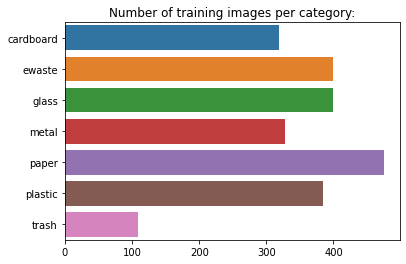

In [3]:
train_data_dir = "/content/drive/MyDrive/dataset_resized/training"

test_data_dir = "/content/drive/MyDrive/dataset_resized/testing"
category_names = sorted(os.listdir('/content/drive/MyDrive/dataset_resized/training'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = '/content/drive/MyDrive/dataset_resized/training' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

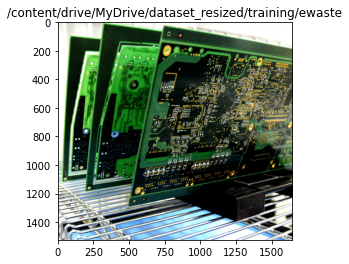

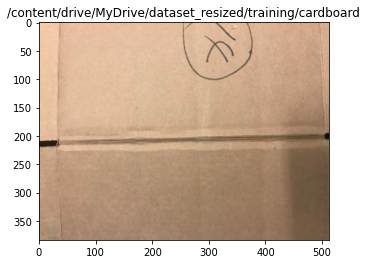

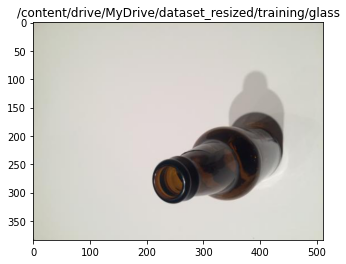

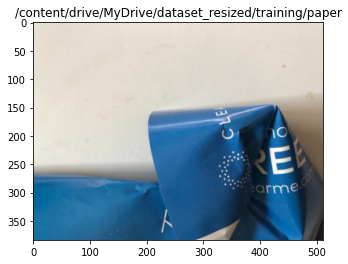

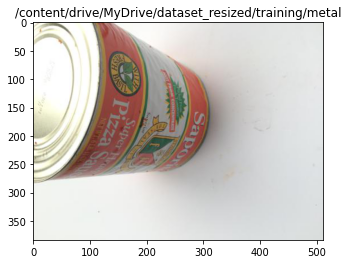

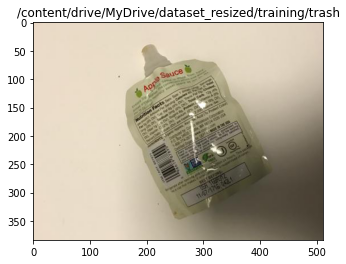

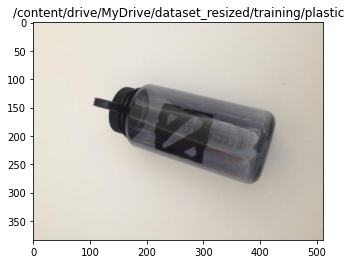

In [4]:
for subdir, dirs, files in os.walk('/content/drive/MyDrive/dataset_resized/training'):
    for file in files:
        img_file = subdir + '/' + file
        image = load_img(img_file)
        plt.figure()
        plt.title(subdir)
        plt.imshow(image)
        break

In [7]:
img_height, img_width = 224,224
conv_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3),classes=1000,
    classifier_activation="softmax",)


94773248/94765736 [==============================] - 1s 0us/step


In [8]:
for layer in conv_base.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f7c027250b8> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f7c027255f8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7c416c7b00> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7c0271eac8> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f7c0271e5c0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f7c025940b8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7bf0276400> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7bf027dbe0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f7bf029d9b0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f7bf02a38d0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7bf02a3a90> True
<tensorflow.python.keras.layers.normaliz

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


In [10]:
#Number of images to load at each iteration
batch_size = 32
# only rescaling
train_datagen =  ImageDataGenerator(
    rescale=1./255
)
test_datagen =  ImageDataGenerator(
    rescale=1./255
)
# these are generators for train/test data that will read pictures #found in the defined subfolders of 'data/'
print('Total number of images for "training":')
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

print('Total number of images for "testing":')
test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
class_mode = "categorical",
shuffle=False)

Total number of images for "training":
Found 2411 images belonging to 7 classes.
Total number of images for "testing":
Found 608 images belonging to 7 classes.


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [12]:
learning_rate = 5e-5
epochs = 50
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10,
                              verbose = 1)
checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])


In [13]:
import numpy as np
from datetime import datetime
import time
#from sklearn import tree
#from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [14]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=test_generator,
                              callbacks=[checkpoint,earlystopping]
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.7833 - acc: 0.6051 
Epoch 00001: val_acc improved from -inf to 0.15625, saving model to sign_classifier.h5
76/76 [==============================] - 1611s 21s/step - loss: 2.7833 - acc: 0.6051 - val_loss: 6.4609 - val_acc: 0.1562
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.2568 - acc: 0.9440
Epoch 00002: val_acc did not improve from 0.15625
76/76 [==============================] - 33s 437ms/step - loss: 0.2568 - acc: 0.9440 - val_loss: 4.3488 - val_acc: 0.1497
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.1046 - acc: 0.9793
Epoch 00003: val_acc improved from 0.15625 to 0.16776, saving model to sign_classifier.h5
76/76 [==============================] - 35s 458ms/step - loss: 0.1046 - acc: 0.9793 - val_loss: 6.4155 - val_acc: 0.1678
Epoch 4/50
76/76 [==============================] - ETA: 0s - l

In [15]:
second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 0:56:47


In [16]:
score=model.evaluate(test_generator,batch_size=128)

19/19 [==============================] - 5s 289ms/step - loss: 1.0132 - acc: 0.8849


In [17]:
model.metrics_names

['loss', 'acc']

In [18]:
score

[1.0131651163101196, 0.8848684430122375]

In [ ]:
score

In [19]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/(88.5)resnet50.h5')

In [20]:
model=load_model('/content/drive/MyDrive/(88.5)resnet50.h5')

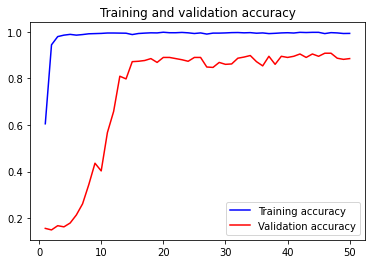

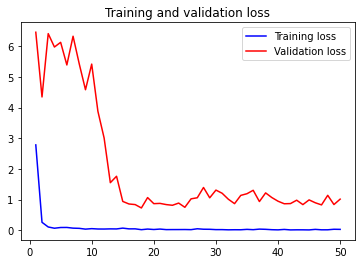

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

In [22]:
import itertools
def plot_confusion_matrix(cm, classes, figname,normalize=False,title='Confusion matrix',cmap=plt.cm.YlOrBr):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    plt.figure(figsize=(8,10))

    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(figname)


Instructions for updating:
Please use Model.predict, which supports generators.
Confusion matrix, without normalization


<Figure size 576x720 with 0 Axes>

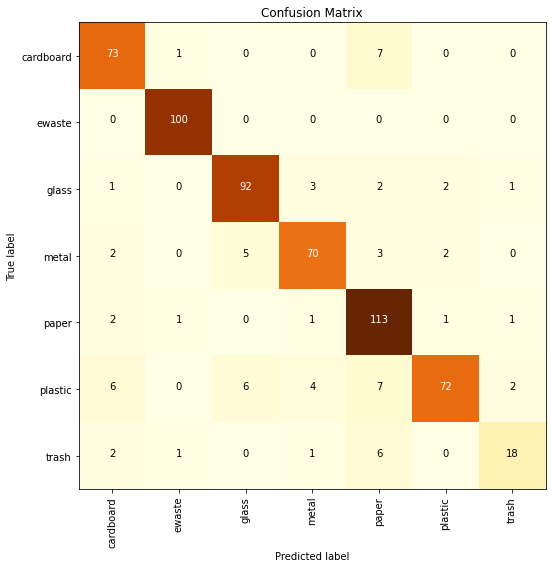

In [23]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

In [24]:
y_pred = model.predict(test_generator)
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 0, 0, 0, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 4, 2, 2, 2, 2, 2, 5, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 5, 2, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3,

In [25]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(256,256))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images,batch_size=8)
  classes = np.argmax(classes, axis=1)
  print(fn)
  print(classes)

Saving Image_1 (4).jpg to Image_1 (4).jpg
Image_1 (4).jpg
[1]


In [27]:
target_names = []
for key in test_generator.class_indices:
    target_names.append(key)

print(target_names)

['cardboard', 'ewaste', 'glass', 'metal', 'paper', 'plastic', 'trash']


Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

   cardboard       0.85      0.90      0.87        81
      ewaste       0.97      1.00      0.99       100
       glass       0.89      0.91      0.90       101
       metal       0.89      0.85      0.87        82
       paper       0.82      0.95      0.88       119
     plastic       0.94      0.74      0.83        97
       trash       0.82      0.64      0.72        28

    accuracy                           0.88       608
   macro avg       0.88      0.86      0.87       608
weighted avg       0.89      0.88      0.88       608



<Figure size 576x720 with 0 Axes>

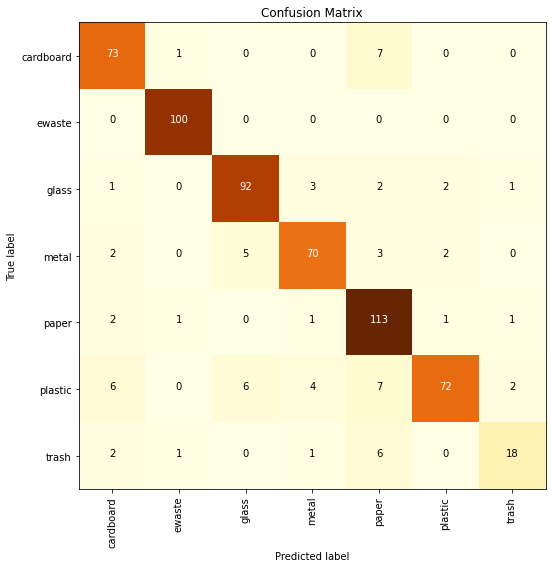

In [28]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix',figname = 'Confusion_matrix.jpg')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [29]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 88.5% 


In [30]:
conv_base =tf.keras.applications.ResNet50 (weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

#for layer in conv_base.layers[:-13]:
#layer.trainable = False
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))

In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        brightness_range = (0.9,1.1),
        fill_mode='nearest'
        )

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
#save_to_dir='augm_images', 
save_prefix='aug', 
save_format='jpg',
class_mode = "categorical")

Found 2411 images belonging to 7 classes.


In [32]:
callbacks = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')

In [33]:
import numpy as np
from datetime import datetime
import time
#from sklearn import tree
#from sklearn.preprocessing import normalize, scale
from sklearn.metrics import accuracy_score
fmt = '%H:%M:%S'
def get_current_time():
    time.ctime()
    return time.strftime(fmt)
first = get_current_time()

In [34]:
learning_rate = 5e-5
epochs = 50
checkpoint = ModelCheckpoint("sign_classifier_augm.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=learning_rate, clipnorm=1.), metrics = ['acc'])
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=test_generator,
                              callbacks=[checkpoint]
                              )

Epoch 1/50
76/76 [==============================] - ETA: 0s - loss: 2.7836 - acc: 0.5927
Epoch 00001: val_acc improved from -inf to 0.13651, saving model to sign_classifier_augm.h5
76/76 [==============================] - 60s 791ms/step - loss: 2.7836 - acc: 0.5927 - val_loss: 7.1066 - val_acc: 0.1365
Epoch 2/50
76/76 [==============================] - ETA: 0s - loss: 0.5387 - acc: 0.8747
Epoch 00002: val_acc improved from 0.13651 to 0.14474, saving model to sign_classifier_augm.h5
76/76 [==============================] - 59s 772ms/step - loss: 0.5387 - acc: 0.8747 - val_loss: 5.8980 - val_acc: 0.1447
Epoch 3/50
76/76 [==============================] - ETA: 0s - loss: 0.3417 - acc: 0.9104
Epoch 00003: val_acc did not improve from 0.14474
76/76 [==============================] - 57s 753ms/step - loss: 0.3417 - acc: 0.9104 - val_loss: 5.0785 - val_acc: 0.1283
Epoch 4/50
76/76 [==============================] - ETA: 0s - loss: 0.1707 - acc: 0.9527
Epoch 00004: val_acc improved from 0.1447

In [35]:
second = get_current_time()
print("Time taken to train(sec):", datetime.strptime(second, fmt) - datetime.strptime(first, fmt))

Time taken to train(sec): 0:50:15


In [38]:
score=model.evaluate(test_generator,batch_size=8)

19/19 [==============================] - 5s 288ms/step - loss: 0.9371 - acc: 0.9194


In [39]:
score

[0.9370966553688049, 0.9194079041481018]

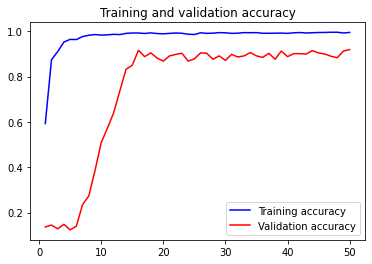

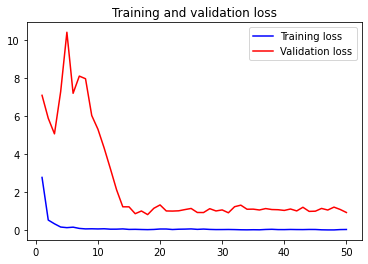

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('Accuracy.jpg')
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('Loss.jpg')

Confusion matrix, without normalization


<Figure size 576x720 with 0 Axes>

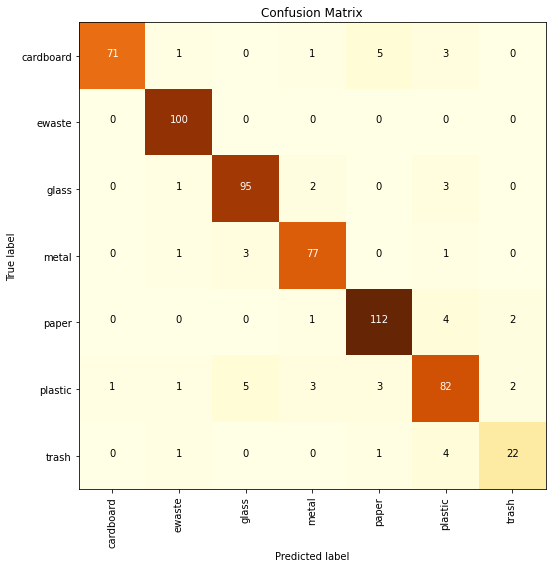

In [41]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, classes = category_names, title='Confusion Matrix', normalize=False, figname = 'Confusion_matrix_concrete.jpg')

In [42]:
y_pred = model.predict(test_generator)
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 4, 4, 0, 0, 0, 4, 0, 0,
       0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 5, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3,

Confusion Matrix
Confusion matrix, without normalization
Classification Report
              precision    recall  f1-score   support

   cardboard       0.99      0.88      0.93        81
      ewaste       0.95      1.00      0.98       100
       glass       0.92      0.94      0.93       101
       metal       0.92      0.94      0.93        82
       paper       0.93      0.94      0.93       119
     plastic       0.85      0.85      0.85        97
       trash       0.85      0.79      0.81        28

    accuracy                           0.92       608
   macro avg       0.91      0.90      0.91       608
weighted avg       0.92      0.92      0.92       608



<Figure size 576x720 with 0 Axes>

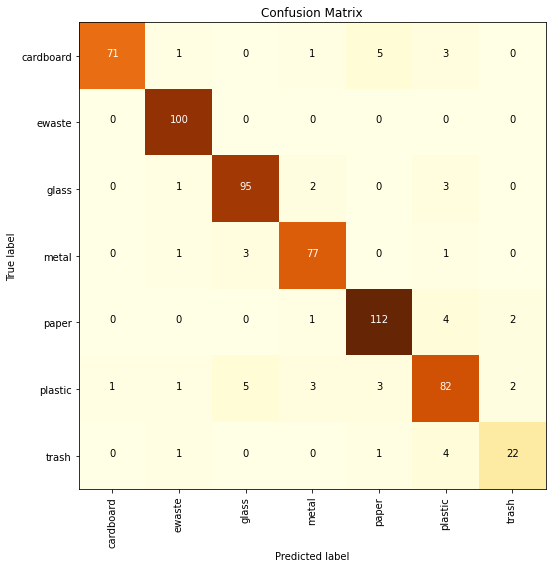

In [43]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix',figname = 'Confusion_matrix.jpg')

#Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [44]:
accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

Accuracy in test set: 91.9% 


In [45]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/resnet50(92%).h5')